# Modele liniowe
##### W tej części analizy zweryfikuję jakoś predykcji modeli liniowych uzyskanych na podstawie wyselekcjonowanych przez nas zmiennych.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error, mean_absolute_error

from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('data/data_after_feature_selection.pkl')

W zbiorze znajdują się obserwacje odstające, które znacznie pogarszają jakość modeli liniowych. Ze względu na ryzyko overfittingu nie możemy pozbyć się ich bezpośrednio. Stąd w modelowaniu będziemy brali pod uwagę tylko rekordy o mniejszej całkowitej historycznej sprzedaży (total_past_sales) mniejszej niż 1500. 

In [3]:
df = df[df['total_past_sales']<1500]

Podczas modelowania liniowego instotne jest również, aby rozkłady każdej ze zmiennych były jak najbliższe rozkładowi normalnemu. 

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


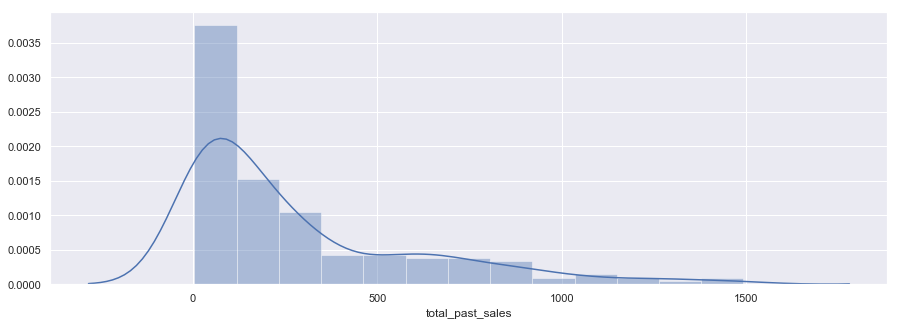

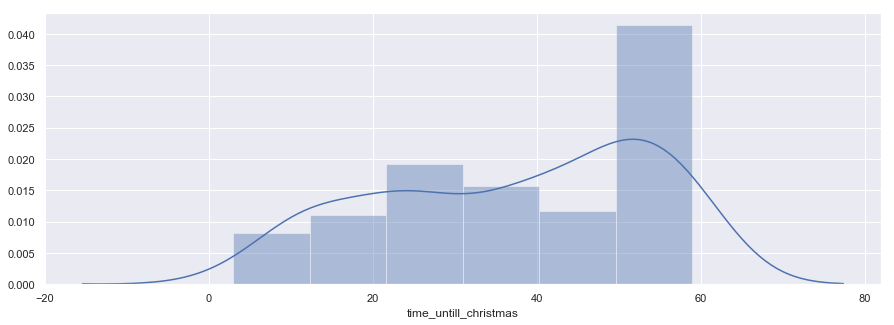

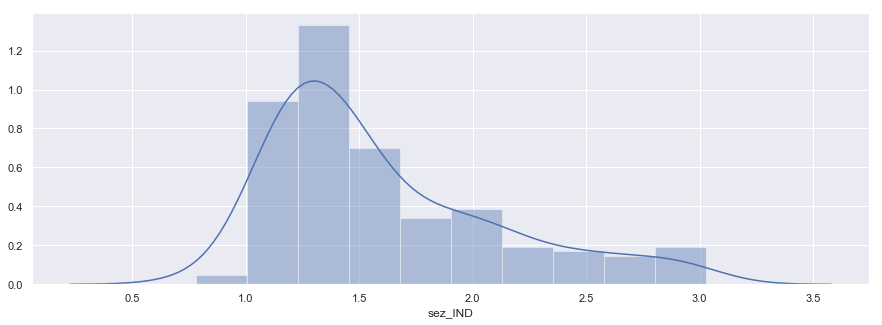

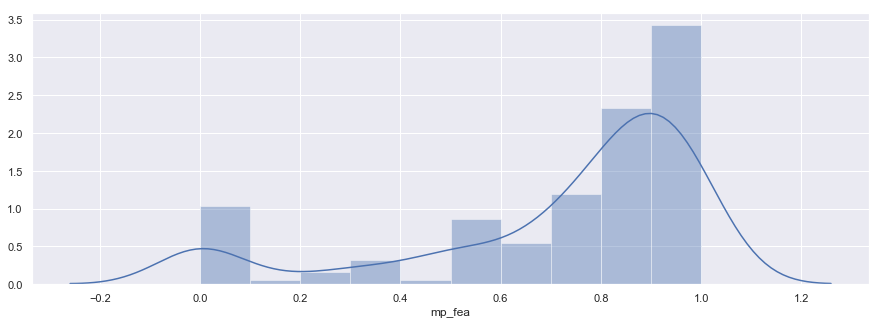

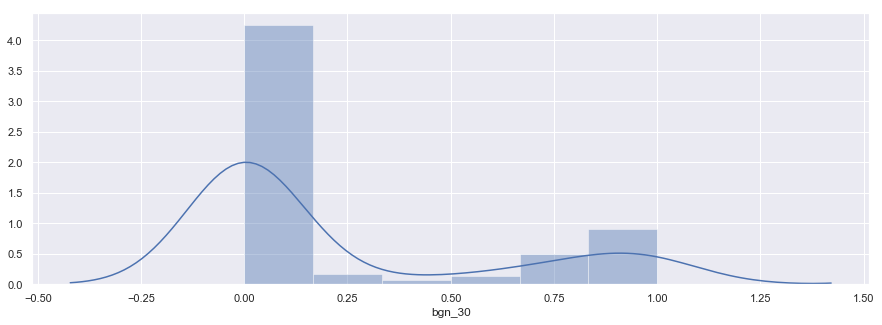

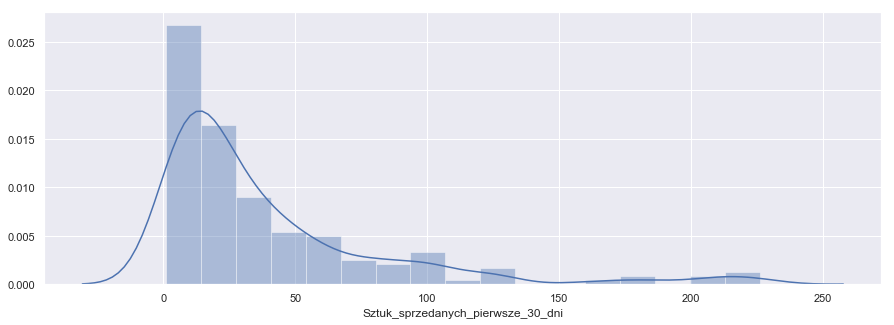

In [4]:
sns.set(rc={'figure.figsize':(15,5)})
for feature in df.columns:
    ax = sns.distplot(df[feature])
    plt.show()
    
sns.set(rc={'figure.figsize':(8,8)})

Rozkład total_past_sales możemy przybliżyć do normalnego transformując ją logarytmem

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


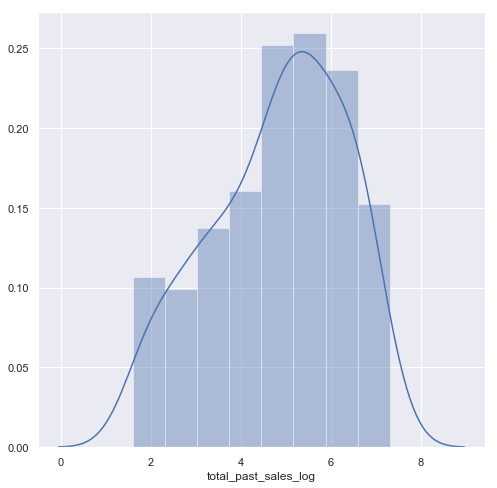

In [5]:
# Tworzymy sztuczną kolumnę z jedynkami, którą dodajemy przed log zmiennej
df['ones'] = np.ones(len(df))
df['total_past_sales_log'] = np.log(df['total_past_sales'] + df['ones'])
df.drop(['total_past_sales', 'ones'], axis=1, inplace=True)
sns.distplot(df['total_past_sales_log'])

#### Podział zbioru na treningowy i walidacyjny.

##### Zdecydowałem się na odłożenie 20% (~40 obserwacji) do zbioru walidacyjnego. Na jego podstawie będę weryfikował jakość uzyskanych modeli. 

In [6]:
X = df.drop('Sztuk_sprzedanych_pierwsze_30_dni', axis=1)
y = df['Sztuk_sprzedanych_pierwsze_30_dni']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

print('Rozmiar zbioru: \nTreningowego: {}\nWalidacyjnego {}'.format(len(X_train), len(X_val)))

Rozmiar zbioru: 
Treningowego: 147
Walidacyjnego 37


Naszym benchmarkiem będzie RMSE przy naiwnej predykcji średnią ze zbioru treningowego.

In [7]:
srednia = np.ones(len(y_val)) * y_train.mean()
rmse = sqrt(mean_squared_error(y_val, srednia))
print('RMSE na zbiorze validacyjnym przy predykcji średnią ze zbioru treningowego: {:.2f}'.format(rmse))

RMSE na zbiorze validacyjnym przy predykcji średnią ze zbioru treningowego: 55.00


Dodatkowo będziemy obserwowali zachowanie mediany błędu absolutnego (MedianAE) i średniej tego błędu (MeanAE). 

## Regresja liniowa

Pierwszymi modelem jaki spróbujemy zbudować jest klasyczna metoda OLS. Sprawdzimy jakie wyniki uda się uzyskać przy trenowaniu na zbiorze treningowym i testowaniu na zbiorze walidacyjnym. Dodatkowo spróbujemy przekształcić nasz target logarytmem by zbliżyć jego rozkład do normalnego.

Regresja liniowa bez przekształcenia zmiennej objaśniane:
RMSE
49.68328673087782
MeanAE:
29.759234043006884
MedianAE:
17.823263282879836
Regresja liniowa z logarytmem zmiennej obj
RMSE
54.55910864135906
MeanAE:
29.98456276451841
MedianAE:
12.114947005683657


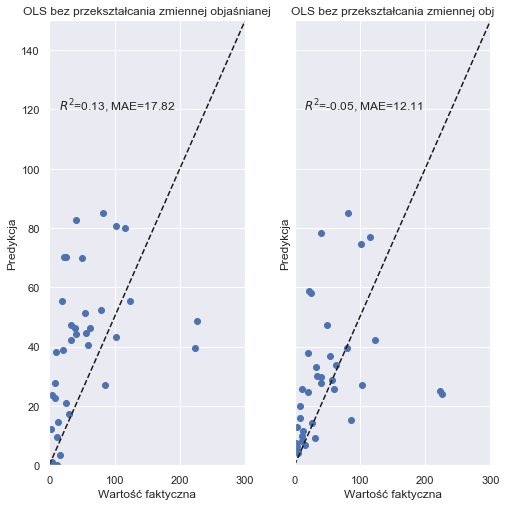

In [9]:
# Inicjalizacja wykresu na którym pokażę wyniki
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

ax0.scatter(y_val, y_pred)
ax0.plot([0, 300], [0, 150], '--k')
ax0.set_ylabel('Predykcja')
ax0.set_xlabel('Wartość faktyczna')
ax0.set_title('OLS bez przekształcania zmiennej objaśnianej')
ax0.text(15, 120, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_val, y_pred), median_absolute_error(y_val, y_pred)))
ax0.set_xlim([0, 300])
ax0.set_ylim([0, 150])

print('Regresja liniowa bez przekształcenia zmiennej objaśniane:')
print('RMSE')
print(sqrt(mean_squared_error(y_val, y_pred)))
print('MeanAE:')
print(mean_absolute_error(y_val, y_pred))
print('MedianAE:')
print(median_absolute_error(y_val, y_pred))

regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_val)

ax1.scatter(y_val, y_pred)
ax1.plot([0, 300], [0, 150], '--k')
ax1.set_ylabel('Predykcja')
ax1.set_xlabel('Wartość faktyczna')
ax1.set_title('OLS bez przekształcania zmiennej obj')
ax1.text(15, 120, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_val, y_pred), median_absolute_error(y_val, y_pred)))
ax1.set_xlim([0, 300])
ax1.set_ylim([0, 150])

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

print('Regresja liniowa z logarytmem zmiennej obj')
print('RMSE')
print(sqrt(mean_squared_error(y_val, y_pred)))
print('MeanAE:')
print(mean_absolute_error(y_val, y_pred))
print('MedianAE:')
print(median_absolute_error(y_val, y_pred))

Widzimy, że wyniki są mocno niezadawalające. RMSE przy klasycznej regresji bez przekształcania zmiennej objaśnianej wynosi 49 czyli tylko o 6 mniej niż w przypadku zastosowania naiwnego podejścia ze średnią. W przypadku regresji liniowej z przekształceniem targetu RMSE jest praktycznie równe benchmarkowi. Jedyną optymistyczną informacją jest spadeć MeanAE i MedianAE, który oznacza, że lepiej dopadowujemy się do danych. 
Według mojej interpretacji za tak wysokie RMSE odpowiedzialna jest duża ilość obserwacji odstających.

Regresja Ridge bez przekształcenia zmiennej objaśniane:
RMSE
49.67723516547599
MeanAE:
29.735738494534928
MedianAE:
17.49368918579114
Regresja Ridge z logarytmem zmiennej objaśnianej:
RMSE
54.60601710796845
MeanAE:
30.07346685648847
MedianAE:
15.10364263235407


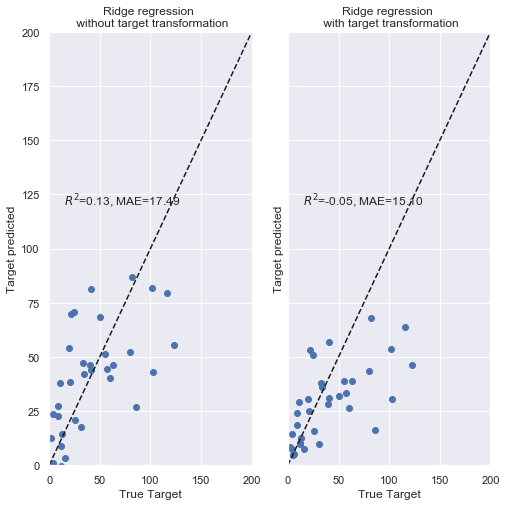

In [15]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV(scoring='neg_median_absolute_error')
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

ax0.scatter(y_val, y_pred)
ax0.plot([0, 200], [0, 200], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(15, 120, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_val, y_pred), median_absolute_error(y_val, y_pred)))
ax0.set_xlim([0, 200])
ax0.set_ylim([0, 200])

print('Regresja Ridge bez przekształcenia zmiennej objaśniane:')
print('RMSE')
print(sqrt(mean_squared_error(y_val, y_pred)))
print('MeanAE:')
print(mean_absolute_error(y_val, y_pred))
print('MedianAE:')
print(median_absolute_error(y_val, y_pred))

regr_trans = TransformedTargetRegressor(regressor=RidgeCV(scoring='neg_median_absolute_error'),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_val)

ax1.scatter(y_val, y_pred)
ax1.plot([0, 200], [0, 200], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(15, 120, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_val, y_pred), median_absolute_error(y_val, y_pred)))
ax1.set_xlim([0, 200])
ax1.set_ylim([0, 200])

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

print('Regresja Ridge z logarytmem zmiennej objaśnianej:')
print('RMSE')
print(sqrt(mean_squared_error(y_val, y_pred)))
print('MeanAE:')
print(mean_absolute_error(y_val, y_pred))
print('MedianAE:')
print(median_absolute_error(y_val, y_pred))